In [2]:
#from sympy import *
#from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation

# Position Control

Eigenvalues: -1.38, -3.62


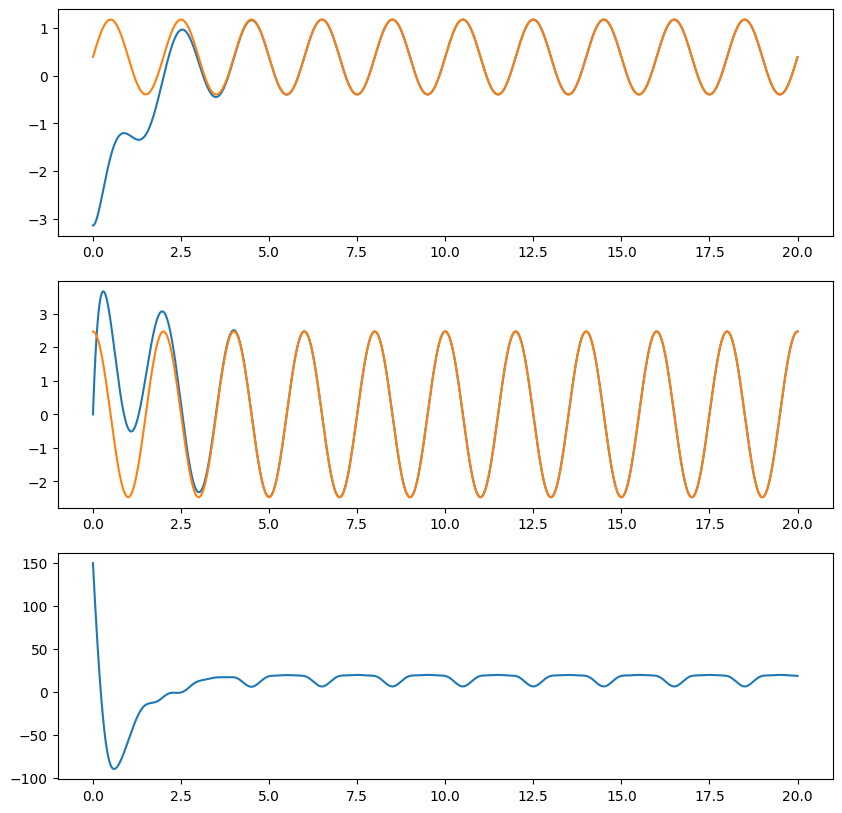

In [2]:
m = 5
l = 1
g = 9.81

K1 = 5
K2 = 5
eigenvalues = np.linalg.eigvals(np.array([[0, 1], [-K1, -K2]]))
print(f'Eigenvalues: {eigenvalues[0]:.2f}, {eigenvalues[1]:.2f}')

dt = 0.001
tf = 20
t = np.arange(0, tf, dt)

theta_d = lambda t: np.pi/4*np.sin(np.pi*t)+np.pi/8
theta_d_dot = lambda t: np.pi**2/4*np.cos(np.pi*t)
theta_d_ddot = lambda t: -np.pi**3/4*np.sin(np.pi*t)

theta_0 = -np.pi
theta_dot_0 = 0

def ode(t, y):
    theta, theta_dot = y
    u = -K1*(theta-theta_d(t)) - K2*(theta_dot-theta_d_dot(t)) + theta_d_ddot(t)
    tau = m*g*l*np.sin(theta) + m*l**2*u
    theta_ddot = (tau - m*g*l*np.sin(theta)) / (m*l**2)
    return [theta_dot, theta_ddot]

sol = solve_ivp(ode, [0, tf], [theta_0, theta_dot_0], t_eval=t)
theta, theta_dot = sol.y

tau = m*g*l*np.sin(theta) + m*l**2*(-K1*(theta-theta_d(t)) - K2*(theta_dot-theta_d_dot(t)) + theta_d_ddot(t))

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(t, theta)
plt.plot(t, theta_d(t))

plt.subplot(3,1,2)
plt.plot(t, theta_dot)
plt.plot(t, theta_d_dot(t))

plt.subplot(3,1,3)
plt.plot(t, tau)
plt.show()

In [22]:
p = lambda th: (l*np.sin(th), -l*np.cos(th))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-3, 1), aspect='equal')
ax.grid()

(x_0, y_0) = p(0)
line = ax.plot([0, x_0], [0, y_0], 'o-', lw=2)[0]

(x_d_1, y_d_1) = p(-np.pi/8)
(x_d_2, y_d_2) = p(3*np.pi/8)
ax.plot([x_d_1, 0, x_d_2], [y_d_1, 0, y_d_2], 'k--', lw=1)[0]

text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fps = 30
def animate(i):
    i = int(i/(fps*dt))
    (x, y) = p(theta[i])
    line.set_data([0, x], [0, y])
    text.set_text(f'time: {t[i]:.1f} s\ntau: {tau[i]:.1f} Nm')

ani = animation.FuncAnimation(fig, animate, frames=fps*tf)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'torque_position_control.mp4', writer=ffmpeg_writer)
plt.close(fig)

# Position Synchronization

Eigenvalues: -1.38, -3.62
Work = -36.85492262138145
-36.85479250455302
-0.6605338376781555 -0.9944769116831056
-0.9950283150859591 -0.9950283150859591


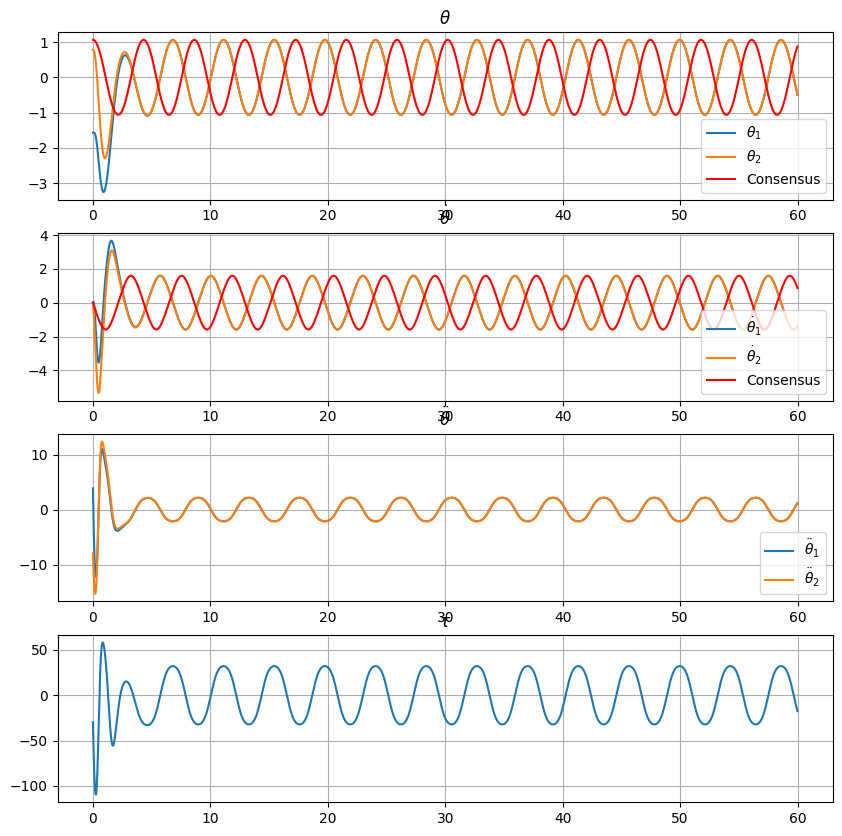

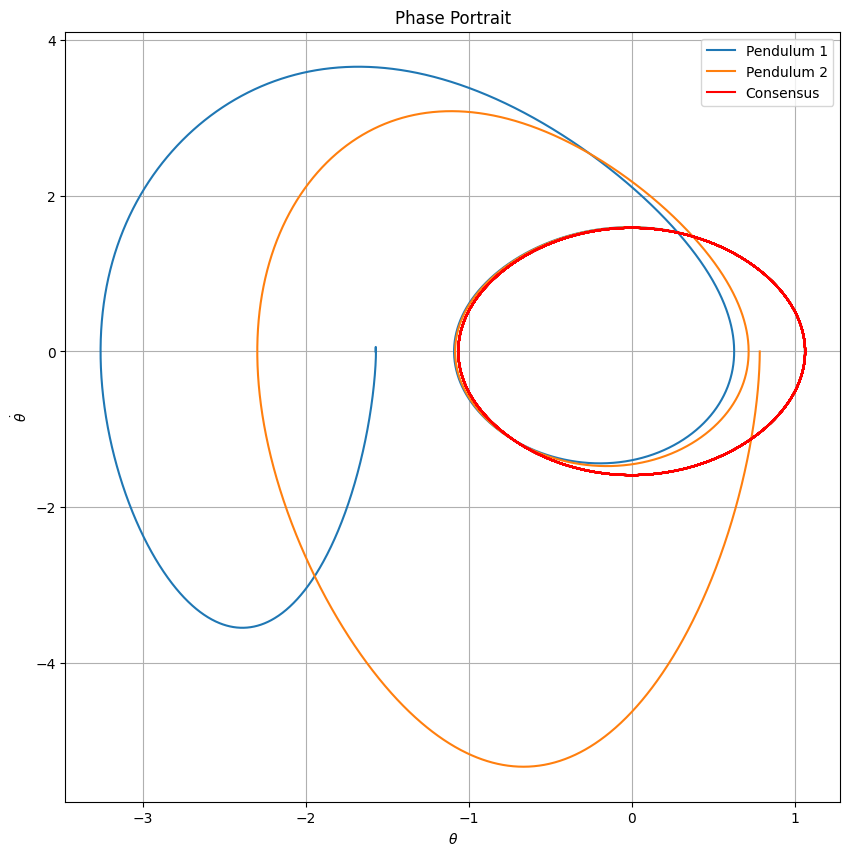

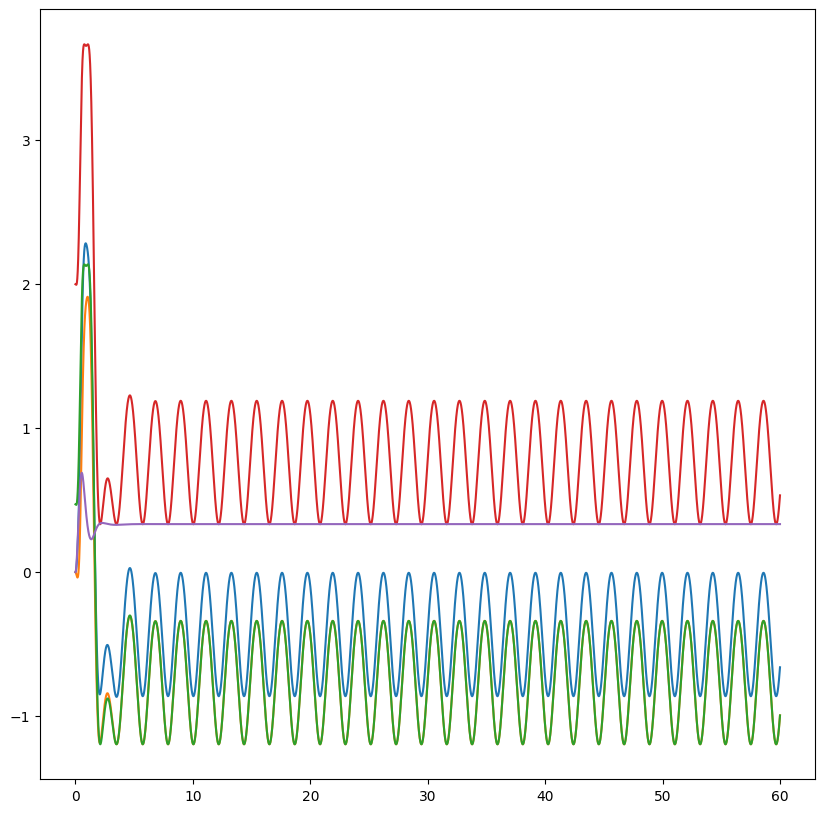

In [45]:
m1 = 5
m2 = 4
l1 = 1
l2 = 1.5
g = 9.81

K1 = 5
K2 = 5
eigenvalues = np.linalg.eigvals(np.array([[0, 1], [-K1, -K2]]))
print(f'Eigenvalues: {eigenvalues[0]:.2f}, {eigenvalues[1]:.2f}')

dt = 0.001
tf = 60
t = np.arange(0, tf, dt)

theta1_0 = -np.pi/2
theta1_dot_0 = 0

theta2_0 = np.pi/4
theta2_dot_0 = 0

def ode(t, y):
    theta1, theta1_dot, theta2, theta2_dot = y
    eR = theta1-theta2
    eW = theta1_dot-theta2_dot
    u = -K1*eR - K2*eW
    tau = 1/(1/(m1*l1**2)-1/(m2*l2**2))*(u+g/l1*np.sin(theta1)-g/l2*np.sin(theta2))
    #if t < 3:
    #    tau = 0
    theta1_ddot = (tau - m1*g*l1*np.sin(theta1)) / (m1*l1**2)
    theta2_ddot = (tau - m2*g*l2*np.sin(theta2)) / (m2*l2**2)
    return [theta1_dot, theta1_ddot, theta2_dot, theta2_ddot]

sol = solve_ivp(ode, [0, tf], [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0], t_eval=t, method='DOP853', rtol=1e-10, atol=1e-10)
theta1, theta1_dot, theta2, theta2_dot = sol.y

tau = 1/(1/(m1*l1**2)-1/(m2*l2**2))*((-K1*(theta1-theta2) - K2*(theta1_dot-theta2_dot))+g/l1*np.sin(theta1)-g/l2*np.sin(theta2))

# Consensus
alpha = -(m1*l1-m2*l2)*g/(m1*l1**2-m2*l2**2)

def ode_c(t, y):
    x1, x2 = y
    return [x2, alpha*np.sin(x1)]

if True:
    E1_0 = 1/2*m1*l1**2*theta1_dot_0**2 - m1*g*l1*np.cos(theta1_0) # Initial energy of pendulum 1
    E2_0 = 1/2*m2*l2**2*theta2_dot_0**2 - m2*g*l2*np.cos(theta2_0) # Initial energy of pendulum 2
    W1 = np.sum(tau*theta1_dot*dt) # Work done on pendulum 1
    W2 = np.sum(tau*theta2_dot*dt) # Work done on pendulum 2
    E_ss = W1+E1_0-(W2+E2_0) # Steady state energy
    theta_c_0 = np.arccos(-E_ss/(m1*l1-m2*l2)/g)
    #theta_c_dot_0 = np.sqrt((E_ss+(m1*l1-m2*l2)*g)/(0.5*(m1*l1**2-m2*l2**2)))
    print('Work =', W1-W2)
    tau_p = 1/(1/(m1*l1**2)-1/(m2*l2**2))*((-K2*(theta1_dot-theta2_dot))+g/l1*np.sin(theta1)-g/l2*np.sin(theta2))
    ini = 1/2*(theta1[0]-theta2[0])**2
    print(np.sum(tau_p*(theta1_dot-theta2_dot)*dt)-K1/(1/(m1*l1**2)-1/(m2*l2**2))*(0-ini))
else:
    T = -1/(1/(m1*l1**2)-1/(m2*l2**2))*(g/l1-g/l2)/(m1*l1)
    theta_c_0 = np.arctan(g/(T-alpha))

sol = solve_ivp(ode_c, [0, tf], [theta_c_0, 0], t_eval=t, method='DOP853', rtol=1e-10, atol=1e-10)
theta_c, theta_c_dot = sol.y

# Plots
plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.plot(t, theta1, label=r'$\theta_1$')
plt.plot(t, theta2, label=r'$\theta_2$')
plt.plot(t, theta_c, color='red', label='Consensus')
plt.title(r'$\theta$')
plt.grid()
plt.legend()

plt.subplot(4,1,2)
plt.plot(t, theta1_dot, label=r'$\dot{\theta}_1$')
plt.plot(t, theta2_dot, label=r'$\dot{\theta}_2$')
plt.plot(t, theta_c_dot, color='red', label='Consensus')
plt.title(r'$\dot{\theta}$')
plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, (tau - m1*g*l1*np.sin(theta1)) / (m1*l1**2), label=r'$\ddot{\theta}_1$')
plt.plot(t, (tau - m2*g*l2*np.sin(theta2)) / (m2*l2**2), label=r'$\ddot{\theta}_2$')
plt.title(r'$\ddot{\theta}$')
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, tau)
plt.title(r'$\tau$')
plt.grid()

plt.figure(figsize=(10,10))
plt.plot(theta1, theta1_dot, label='Pendulum 1')
plt.plot(theta2, theta2_dot, label='Pendulum 2')
plt.plot(theta_c, theta_c_dot, color='red', label='Consensus')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('Phase Portrait')
plt.legend()
plt.grid()
#plt.xlim(1.65, 1.85)
#plt.ylim(-.5, .5)
#plt.xlim(.9, 1)
#plt.ylim(1.9, 2)

term1 = np.cumsum(np.sin(theta1)/l1*theta2_dot*dt + np.sin(theta2)/l2*theta1_dot*dt)
term2 = np.cumsum(np.sin(theta1)/l1*theta1_dot*dt + np.sin(theta2)/l2*theta2_dot*dt)
plt.figure(figsize=(10,10))
plt.plot(t, term1)
plt.plot(t, term2)
plt.plot(t, -(1/l1+1/l2)*np.cos(theta1)+np.cos(theta1[0])/l1+np.cos(theta2[0])/l2)
plt.plot(t, -(1/l1+1/l2)*np.cos(theta1)+2)
plt.plot(t, term1-term2)
print(term1[-1], term2[-1])
print(np.cos(theta1[0])/l1+np.cos(theta2[0])/l2-(1/l1+1/l2)*np.cos(theta1[-1]), np.cos(theta1[0])/l1+np.cos(theta2[0])/l2-(1/l1+1/l2)*np.cos(theta1[-1]))

In [21]:
np.where(np.abs(theta1_dot) < 1e-3)[-1]

array([    0,  1872,  2949,  5223, 10264, 15289, 17797])

In [3]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-3, 1), aspect='equal')
ax.grid()

# Plot initial position
line1 = ax.plot([0, l1*np.sin(theta1[0])], [0, -l1*np.cos(theta2[0])], 'o-', lw=2)[0]
line2 = ax.plot([0, l2*np.sin(theta2[0])], [0, -l2*np.cos(theta2[0])], 'o-', lw=2)[0]

# Text box for time and torque
text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fps = 30
def animate(i):
    i = int(i/(fps*dt))
    line1.set_data([0, l1*np.sin(theta1[i])], [0, -l1*np.cos(theta1[i])])
    line2.set_data([0, l2*np.sin(theta2[i])], [0, -l2*np.cos(theta2[i])])
    text.set_text(f'time: {t[i]:.1f} s\ntau: {tau[i]:.1f} Nm')

ani = animation.FuncAnimation(fig, animate, frames=fps*tf)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'real_control.mp4', writer=ffmpeg_writer)
plt.close(fig)